In [1]:
using Distributions
using RCall
using StatsPlots

default(fmt=:png, titlefontsize=10)
@rlibrary stats

function pvalue_clopper_pearson(model::DiscreteUnivariateDistribution, data)
    min(1, 2cdf(model, data), 2ccdf(model, data-1))
end

x ⪅ y = x < y || x ≈ y

function pvalue_sterne(model::DiscreteUnivariateDistribution, data)
    p0 = pdf(model, data)
    p0 == 0 && return 0.0
    p0 == 1 && return 1.0
    m = mode(model)
    pdf(model, m) ≈ p0 && return 1.0
    if data > m
        i = m - 1
        while !(pdf(model, i) ⪅ p0) i -= 1 end
        return cdf(model, i) + ccdf(model, data-1)
    else # data < m
        i = m + 1
        while !(pdf(model, i) ⪅ p0) i += 1 end
        return cdf(model, data) + ccdf(model, i-1)
    end
end

label = ["Sterne" "Clopper-Pearson" "R"]
ls = [:solid :dash :dashdot]
ytick = 0:0.05:1
xguide = "data"
yguide = "P-value"

"P-value"

model = Binomial{Float64}(n=20, p=0.5)
datas = 0:20


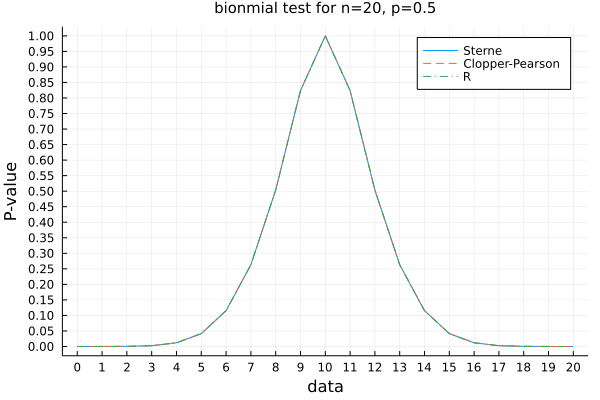

In [2]:
n, p = 20, 0.5
model = Binomial(n, p)
datas = support(model)
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(binom_test(x, n; p))[:p_value] for x in datas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide, yguide)
title!("bionmial test for n=$n, p=$p")

model = Binomial{Float64}(n=20, p=0.37)
datas = 0:20


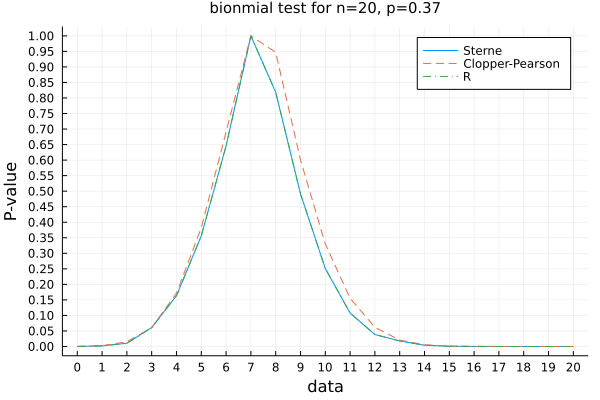

In [3]:
n, p = 20, 0.37
model = Binomial(n, p)
datas = support(model)
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(binom_test(x, n; p))[:p_value] for x in datas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide, yguide)
title!("bionmial test for n=$n, p=$p")

model = Hypergeometric(ns=19, nf=21, n=15)
datas = 0:15


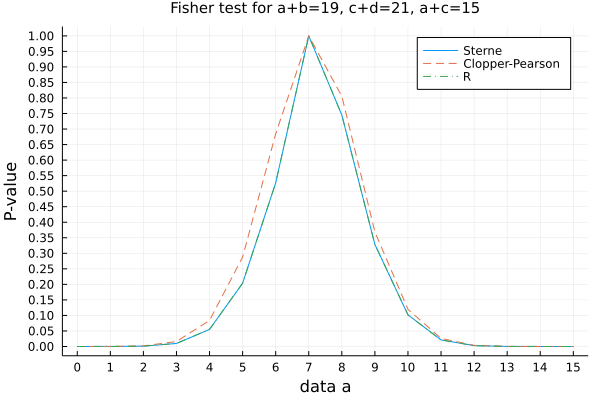

In [4]:
m, n, r = 19, 21, 15
model = Hypergeometric(m, n, r)
datas = support(model)
matdatas = [[a m-a; r-a n-r+a] for a in datas]
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(fisher_test(x))[:p_value] for x in matdatas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide="data a", yguide)
title!("Fisher test for a+b=$m, c+d=$n, a+c=$r")

model = Poisson{Float64}(λ=5.0)
datas = 0:15


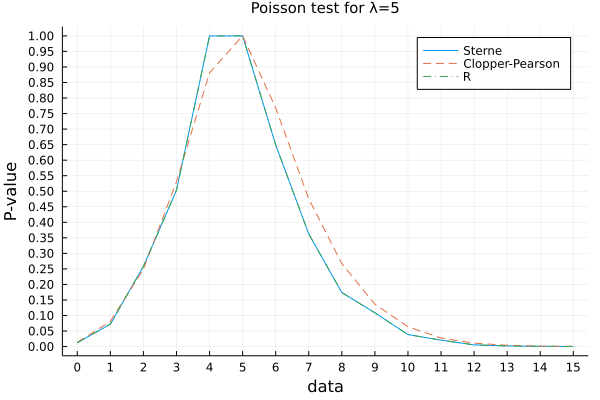

In [5]:
λ = 5
model = Poisson(λ)
datas = 0:15
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(poisson_test(x, λ))[:p_value] for x in datas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide="data", yguide)
title!("Poisson test for λ=$λ")

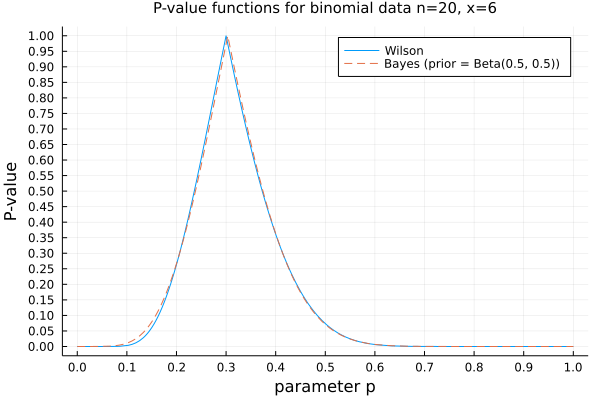

In [6]:
using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10)

safediv(x, y) = x == 0 ? float(x) : y == Inf ? zero(float(y)) : x/y

function pvalue_wilson(model::Binomial, data)
    n = ntrials(model)
    p = succprob(model)
    mu = n*p
    se = √(n*p*(1-p))
    z = safediv(data - mu, se)
    2ccdf(Normal(), abs(z))
end

function posterior(model::Binomial, data; conjprior=Beta(0.5, 0.5))
    n = ntrials(model)
    a, b = params(conjprior)
    Beta(a + data, b + n - data)
end

function pvalue_bayes(model::Binomial, data; conjprior=Beta(0.5, 0.5))
    posterior_dist = posterior(model, data; conjprior)
    p = succprob(model)
    min(1, 2cdf(posterior_dist, p), 2ccdf(posterior_dist, p))
end

n, data = 20, 6
conjprior = Beta(0.5, 0.5)
plot(p -> pvalue_wilson(Binomial(n, p), data); label="Wilson")
plot!(p -> pvalue_bayes(Binomial(n, p), data; conjprior);
    label="Bayes (prior = Beta$(params(conjprior)))", ls=:dash)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)
plot!(xguide="parameter p", yguide="P-value")
title!("P-value functions for binomial data n=$n, x=$data")

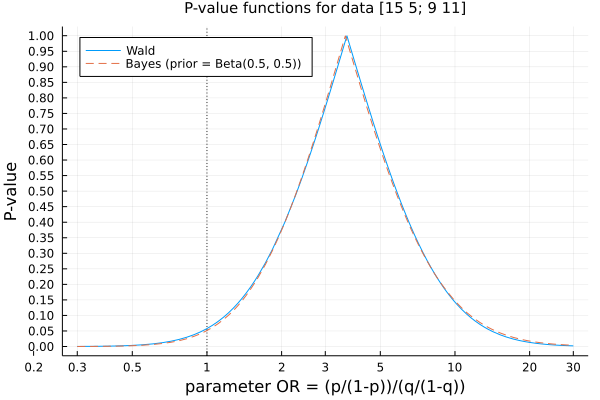

In [7]:
using StatsBase: ecdf

function pvalue_oddsratio_wald(a, b, c, d, ω=1.0)
    logORhat = log(safediv(a*d, b*c))
    SEhat_logORhat = √(1/a + 1/b + 1/c + 1/d)
    2ccdf(Normal(), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function make_pvalue_oddsratio_bayes(a, b, c, d, ω=1.0; L=10^6)
    (a+b == 0 || c+d == 0) && return ω -> 1.0
    bin1, bin2 = Binomial(a+b, safediv(a, a+b)), Binomial(c+d, safediv(c, c+d))
    post1, post2 = posterior(bin1, a), posterior(bin2, c)
    p, q = rand(post1, L), rand(post2, L)
    or = @. safediv(p*(1-q), (1-p)*q)
    ecdf_or = ecdf(or)
    pvalue_oddsratio_bayes(ω) = min(1, 2ecdf_or(ω), 2(1-ecdf_or(ω)))
end

a, b, c, d = 15, 5, 9, 11
pvalue_oddsratio_bayes = make_pvalue_oddsratio_bayes(a, b, c, d)

xtick = Any[0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 100]
plot(ω -> pvalue_oddsratio_wald(a, b, c, d, ω), 0.3, 30; label="Wald")
plot!(ω -> pvalue_oddsratio_bayes(ω), 0.3, 30;
    label="Bayes (prior = Beta$(params(conjprior)))", ls=:dash)
vline!([1]; label="", c=:black, ls=:dot)
plot!(xscale=:log10, xtick=(xtick, string.(xtick)), ytick=0:0.05:1)
plot!(xguide="parameter OR = (p/(1-p))/(q/(1-q))", yguide="P-value")
title!("P-value functions for data [$a $b; $c $d]")
plot!(legend=:topleft)

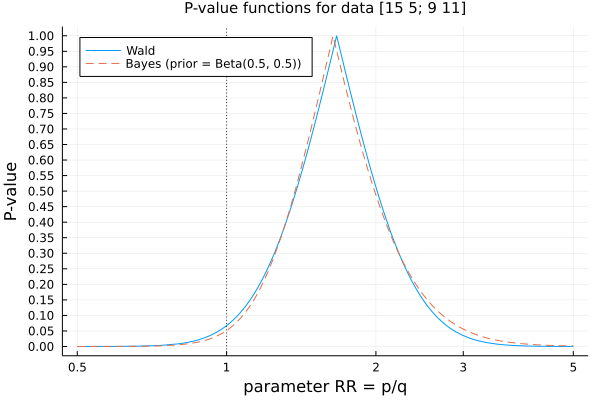

In [8]:
using StatsBase: ecdf

function pvalue_rateratio_wald(a, b, c, d, ρ=1.0)
    (a+b == 0 || c+d == 0) && return 1.0
    logRRhat = log(safediv(a*(c+d), (a+b)*c))
    SEhat_logRRhat = √(1/a - 1/(a+b) + 1/c - 1/(c+d))
    2ccdf(Normal(), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function make_pvalue_rateratio_bayes(a, b, c, d, ρ=1.0; L=10^6)
    (a+b == 0 || c+d == 0) && return ω -> 1.0
    bin1, bin2 = Binomial(a+b, safediv(a, a+b)), Binomial(c+d, safediv(c, c+d))
    post1, post2 = posterior(bin1, a), posterior(bin2, c)
    p, q = rand(post1, L), rand(post2, L)
    rr = @. safediv(p, q)
    ecdf_rr = ecdf(rr)
    pvalue_rateratio_bayes(ρ) = min(1, 2ecdf_rr(ρ), 2(1-ecdf_rr(ρ)))
end

a, b, c, d = 15, 5, 9, 11
pvalue_rateratio_bayes = make_pvalue_rateratio_bayes(a, b, c, d)

xtick = Any[0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 100]
plot(ρ -> pvalue_rateratio_wald(a, b, c, d, ρ), 0.5, 5; label="Wald")
plot!(ρ -> pvalue_rateratio_bayes(ρ), 0.5, 5;
    label="Bayes (prior = Beta$(params(conjprior)))", ls=:dash)
vline!([1]; label="", c=:black, ls=:dot)
plot!(xscale=:log10, xtick=(xtick, string.(xtick)), ytick=0:0.05:1)
plot!(xguide="parameter RR = p/q", yguide="P-value")
title!("P-value functions for data [$a $b; $c $d]")
plot!(legend=:topleft)